In [1]:
import pandas as pd
import numpy as np
import warnings
import os
from functools import reduce
warnings.filterwarnings(action='ignore')

import seaborn as sns

sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

sns.set(rc = {'figure.figsize':(15,7)})

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
def get_season(x):
    season = ''
    if (x == 1) or (x == 2) or (x == 12):
        season = 'winter'
    elif (x == 3) or (x == 4) or (x == 5):
        season = 'spring'
    elif (x == 6) or (x == 7) or (x == 8):
        season = 'summer'
    elif (x == 9) or (x == 10) or (x == 11):
        season = 'fall'
    else:
        season = ''
    return season

**Notation**
- 연령대가 포함되어 있는 국내 유동인구와 음식물 쓰레기 배출량과의 관계 탐색 => 연령대를 묶었을 때 : 0+10(아동 청소년) / 20+30(청년) / 40+50(중년) / 60+70+80(장노년)
- 제주 거주인구의 상관관계 쪽이 특징이 일관되며 두드러짐

In [3]:
waste = pd.read_csv('01_제공데이터/01_음식물쓰레기_FOOD_WASTE.CSV',encoding='cp949')
local = pd.read_pickle('01_제공데이터/02-1_내국인유동인구_KOREAN.pickle')

waste['base_date'] = pd.to_datetime(waste['base_date'])
waste['month'] = waste['base_date'].dt.month
waste['season'] = waste['month'].apply(lambda x: get_season(x)).astype('category')
local['base_date'] = pd.to_datetime(local['base_date'])
local['month'] = local['base_date'].dt.month
local['season'] = local['month'].apply(lambda x: get_season(x)).astype('category')

In [4]:
age_label = {0:'청소년', 10:'청소년', 20:'청년', 30:'청년', 40:'중년', 50:'중년', 60:'장노년', 70:'장노년', 80:'장노년'}
local['age_group'] = local[['age']].replace({'age':age_label})

In [5]:
waste.head()

,base_date,city,emd_cd,emd_nm,em_area_cd,em_cnt,em_g,pay_amt,month,season
0,2018-01-01,제주시,50110670,외도동,W6X062,2,15500,464,1,winter
1,2018-01-01,제주시,50110630,아라동,W6XA97,25,59800,1787,1,winter
2,2018-01-01,제주시,50110630,아라동,W6XA96,8,25350,758,1,winter
3,2018-01-01,제주시,50110630,아라동,W6XA95,12,30000,898,1,winter
4,2018-01-01,제주시,50110630,아라동,W6XA94,14,44050,1317,1,winter


In [6]:
local.head()

,base_date,time,city,emd_cd,emd_nm,sex,age,resd_pop_cnt,work_pop_cnt,visit_pop_cnt,resd,month,season,age_group
0,2018-01-01,1,제주시,50110250,한림읍,여성,0,638.5509,15.5400,151.5149,제주,1,winter,청소년
1,2018-01-01,1,제주시,50110250,한림읍,여성,0,0.0000,3.7249,171.3458,그외,1,winter,청소년
2,2018-01-01,1,제주시,50110250,한림읍,여성,10,668.4577,17.0308,166.0500,제주,1,winter,청소년
3,2018-01-01,1,제주시,50110250,한림읍,여성,10,0.0000,4.2577,195.8539,그외,1,winter,청소년
4,2018-01-01,1,제주시,50110250,한림읍,여성,20,609.7710,5.9490,148.7246,제주,1,winter,청년


# 전체

In [7]:
waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().corr()

,em_cnt,em_g,pay_amt
em_cnt,1.000000,0.891084,0.867387
em_g,0.891084,1.000000,0.970358
pay_amt,0.867387,0.970358,1.000000


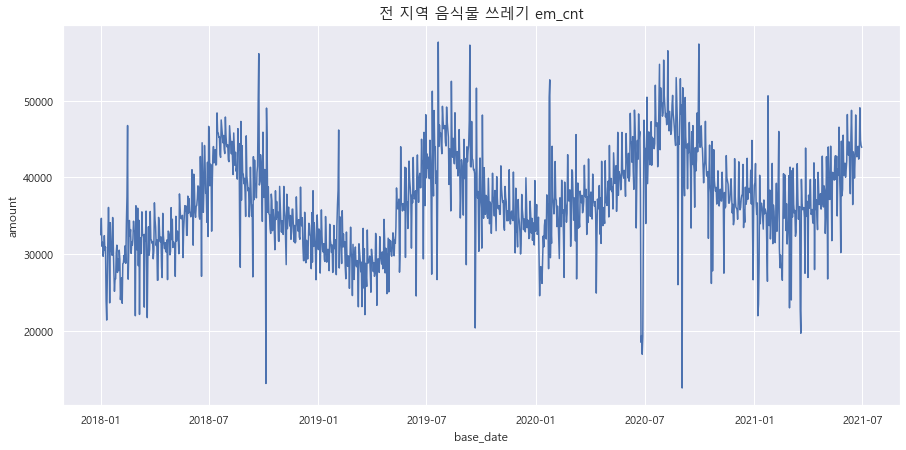

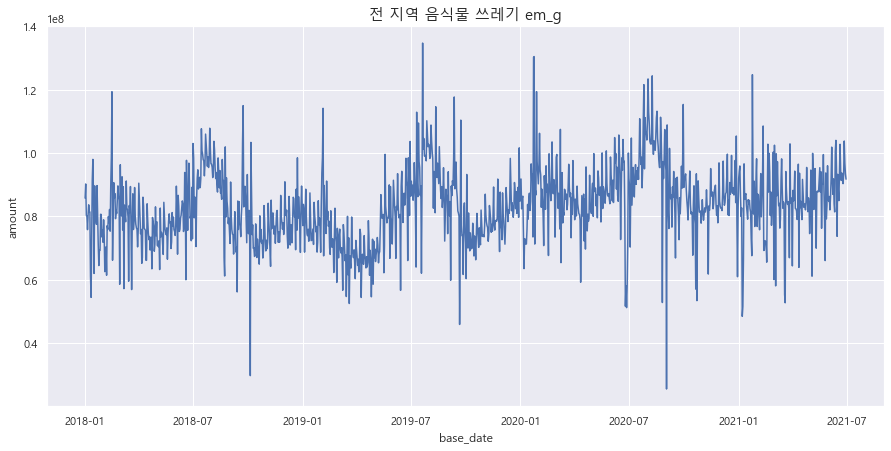

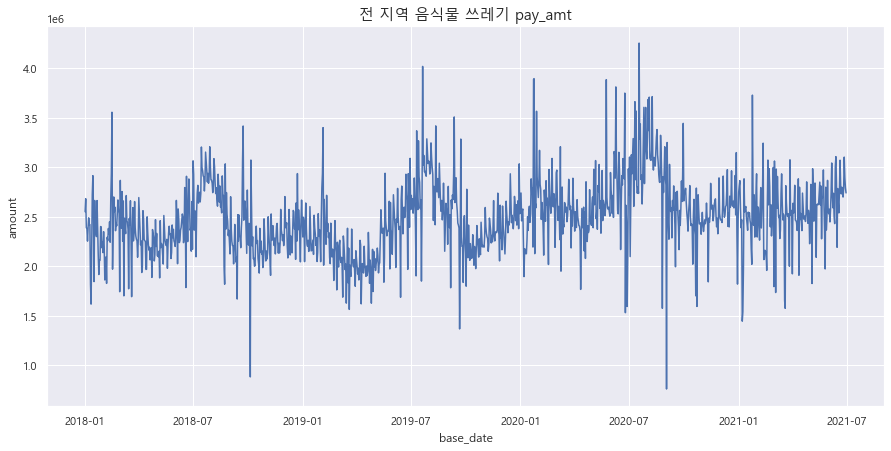

In [8]:
total_waste = waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().stack().reset_index()
total_waste.columns = ['base_date','em','amount']

for em in total_waste['em'].unique():
    sns.lineplot(data=total_waste[total_waste['em'] == em],x='base_date',y='amount')
    plt.title('전 지역 음식물 쓰레기 {}'.format(em), fontsize=15)
    plt.show()

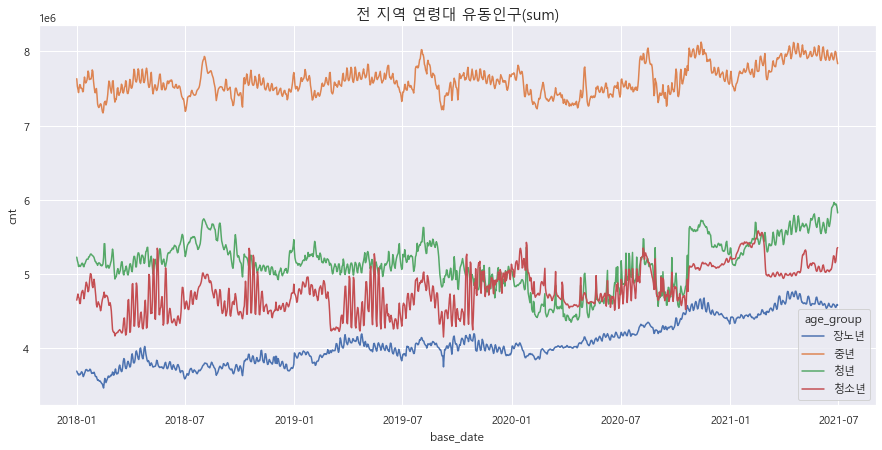

In [9]:
total_age = local.groupby(['base_date','age_group'])['resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt'].sum().stack().reset_index()
total_age.columns = ['base_date','age_group','pop','cnt']
total_age = total_age.groupby(['base_date','age_group'])['cnt'].sum().reset_index()

sns.lineplot(data=total_age, x='base_date',y='cnt',hue='age_group')
plt.title('전 지역 연령대 유동인구(sum)', fontsize=15)
plt.show()

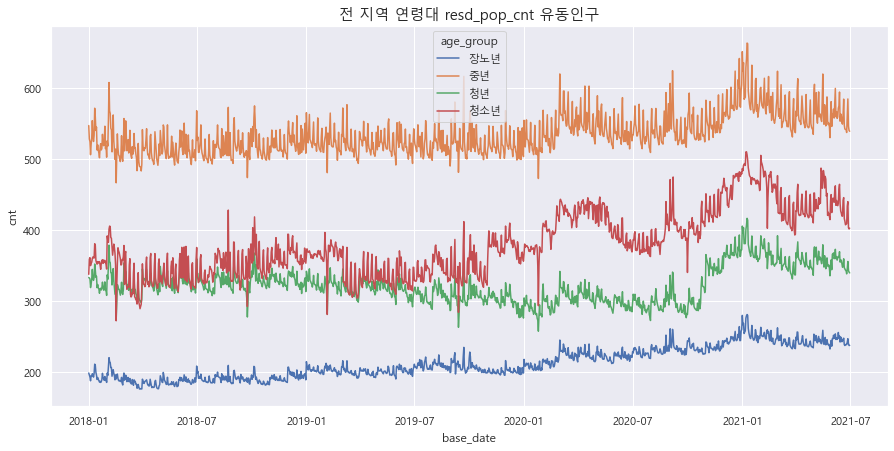

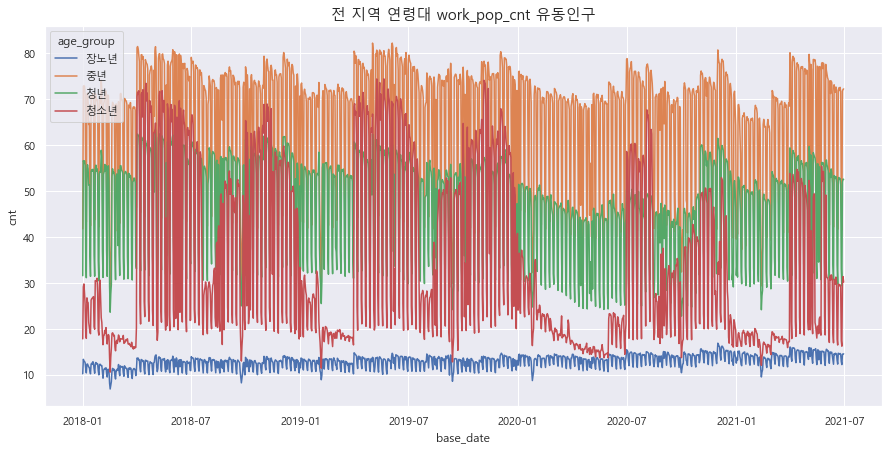

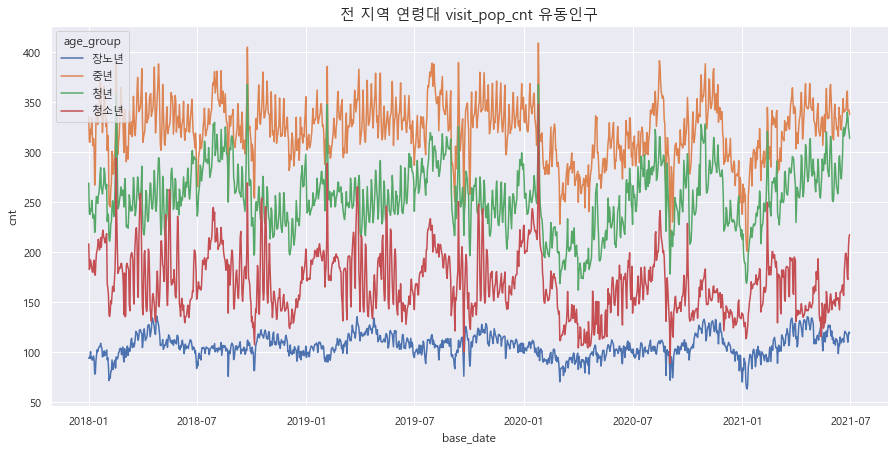

In [10]:
total_age = local.groupby(['base_date','age_group'])['resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt'].mean().stack().reset_index()
total_age.columns = ['base_date','age_group','pop','cnt']

for pop in total_age['pop'].unique():
    sns.lineplot(data=total_age[total_age['pop'] == pop], x='base_date',y='cnt',hue='age_group')
    plt.title('전 지역 연령대 {} 유동인구'.format(pop), fontsize=15)
    plt.show()

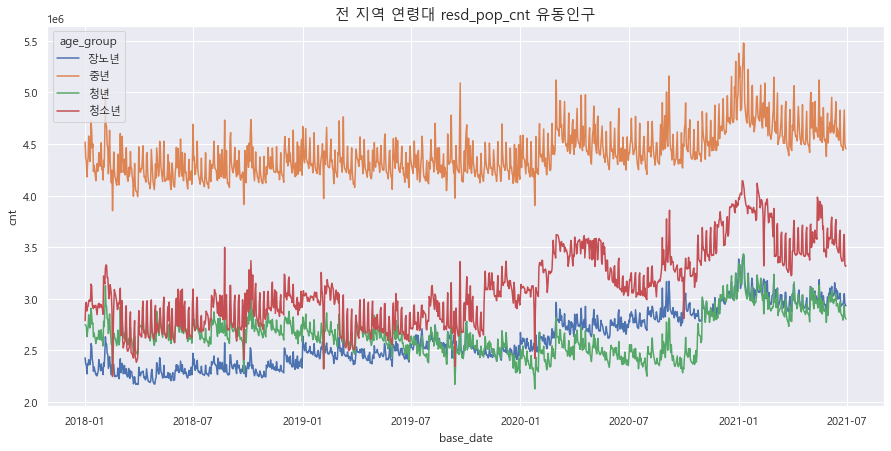

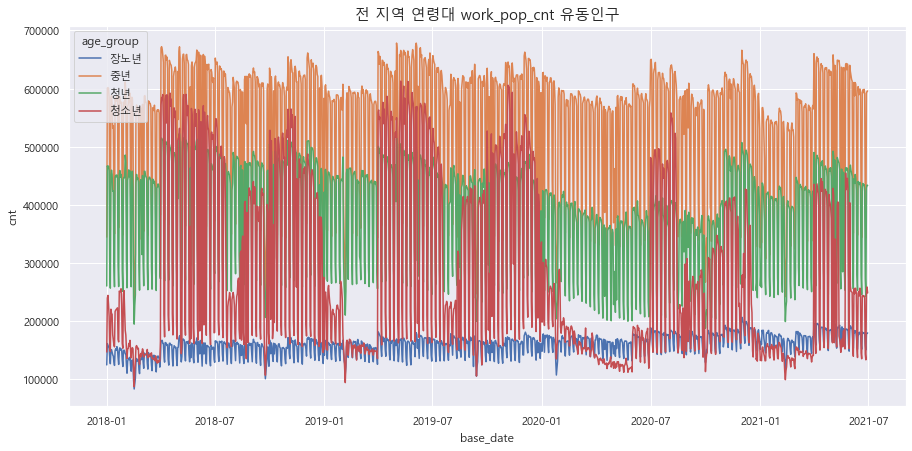

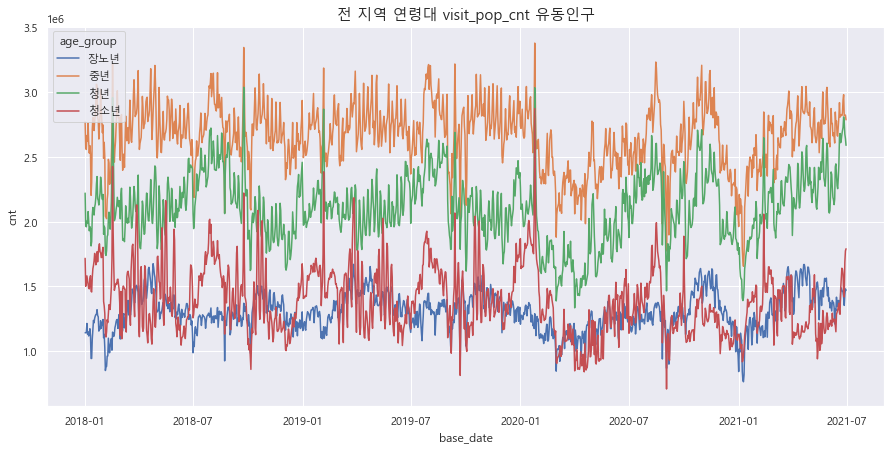

In [11]:
total_age = local.groupby(['base_date','age_group'])['resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt'].sum().stack().reset_index()
total_age.columns = ['base_date','age_group','pop','cnt']

for pop in total_age['pop'].unique():
    sns.lineplot(data=total_age[total_age['pop'] == pop], x='base_date',y='cnt',hue='age_group')
    plt.title('전 지역 연령대 {} 유동인구'.format(pop), fontsize=15)
    plt.show()

# 배출량, 배출횟수, 연령별 총 유동인구 상관관계(월별 집계)
- 제주에 거주하는 인구가 음식물 쓰레기 데이터와 상관계수가 높음

In [17]:
total_age = local.groupby(['base_date','month','emd_nm','resd','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].sum().stack().reset_index()
total_age.columns = ['base_date','month','emd_nm','resd','age_group','pop','cnt']
total_age = total_age.groupby(['base_date','month','emd_nm','resd','age_group'])['cnt'].sum().reset_index()
total_age = total_age.groupby(['month','emd_nm','resd','age_group'])['cnt'].mean().reset_index()
total_age['age_col'] = total_age.apply(lambda x:'%s %s' % (x['resd'],x['age_group']),axis=1)

total_age_pivot = total_age.pivot_table(index=['month','emd_nm'],columns=['age_col'], values=['cnt'],aggfunc='sum').reset_index()
total_age_pivot.columns = list(total_age_pivot.columns.get_level_values(0)[:2]) + list(total_age_pivot.columns.get_level_values(1)[2:])

emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_g','em_cnt'].sum().reset_index()
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_g','em_cnt'].mean().reset_index()

new_age = pd.merge(emg_waste, total_age_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
new_age.corr().style.background_gradient(cmap='summer_r')

,em_g,em_cnt,그외 장노년,그외 중년,그외 청년,그외 청소년,제주 장노년,제주 중년,제주 청년,제주 청소년
em_g,1.000000,0.985589,0.290700,0.269318,0.277284,0.420774,0.800903,0.877996,0.883665,0.907539
em_cnt,0.985589,1.000000,0.251436,0.231206,0.242852,0.377412,0.767109,0.859666,0.874665,0.901593
그외 장노년,0.290700,0.251436,1.000000,0.972177,0.908450,0.787754,0.693074,0.616515,0.531520,0.431183
그외 중년,0.269318,0.231206,0.972177,1.000000,0.965194,0.862170,0.649177,0.589678,0.515167,0.403612
그외 청년,0.277284,0.242852,0.908450,0.965194,1.000000,0.866197,0.621681,0.568080,0.510693,0.395742
그외 청소년,0.420774,0.377412,0.787754,0.862170,0.866197,1.000000,0.679319,0.655739,0.609714,0.540051
제주 장노년,0.800903,0.767109,0.693074,0.649177,0.621681,0.679319,1.000000,0.964190,0.915356,0.880790
제주 중년,0.877996,0.859666,0.616515,0.589678,0.568080,0.655739,0.964190,1.000000,0.978200,0.956133
제주 청년,0.883665,0.874665,0.531520,0.515167,0.510693,0.609714,0.915356,0.978200,1.000000,0.971265
제주 청소년,0.907539,0.901593,0.431183,0.403612,0.395742,0.540051,0.880790,0.956133,0.971265,1.000000


In [18]:
new_age.corr()[(new_age.corr()['em_g']>0.7)|(new_age.corr()['em_cnt']>0.7)|(new_age.corr()['em_g']<-0.7)|(new_age.corr()['em_cnt']>0.7)][['em_g','em_cnt']].sort_values(by=['em_g','em_cnt'],ascending=False)[2:].T

,제주 청소년,제주 청년,제주 중년,제주 장노년
em_g,0.907539,0.883665,0.877996,0.800903
em_cnt,0.901593,0.874665,0.859666,0.767109


# 연령대 재정의
- 배출량과 배출건수 모두 TOP3인 경우 : 제주 거주 청소년, 청년, 중년의 거주인구(예외 : 배출건수에서 제주 거주 청소년 방문인구 2위)
- 그외 거주 유동인구의 영향이 거의 없는 것으로 보임 => 상관계수로 봤을 때, 제주 거주인구 쪽이 상위권
- 방문인구의 경우 제주 거주 청년과 청소년의 상관계수가 높게 나옴 => 젊은 층의 활발한 생활권 영향?

In [27]:
# 쓰레기 배출량과 (새로 정의한) 연령대별 모든 종류의 유동인구 간 상관관계
emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_g'].sum().reset_index()
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_g'].mean().reset_index()
total_age = local.groupby(['base_date','month','emd_nm','resd','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].sum().reset_index()
total_age = total_age.groupby(['month','emd_nm','resd','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index()

total_age.columns = ['month','emd_nm','resd','age_group','pop','cnt']
total_age.drop(total_age[(total_age['resd'] == '그외') & (total_age['pop'] == 'resd_pop_cnt')].index, inplace = True)
total_age['pop_col'] = total_age.apply(lambda x:'%s %s %s' % (x['resd'],x['age_group'], x['pop'][:-8]),axis=1)
total_age_pivot = total_age.pivot_table(index=['month','emd_nm'],columns=['pop_col'], values=['cnt'],aggfunc='sum').reset_index()

total_age_pivot.columns = list(total_age_pivot.columns.get_level_values(0)[:2]) + list(total_age_pivot.columns.get_level_values(1)[2:])

new_age_g = pd.merge(emg_waste, total_age_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
new_age_g.corr().style.background_gradient(cmap='summer_r')

,em_g,그외 장노년 visit,그외 장노년 work,그외 중년 visit,그외 중년 work,그외 청년 visit,그외 청년 work,그외 청소년 visit,그외 청소년 work,제주 장노년 resd,제주 장노년 visit,제주 장노년 work,제주 중년 resd,제주 중년 visit,제주 중년 work,제주 청년 resd,제주 청년 visit,제주 청년 work,제주 청소년 resd,제주 청소년 visit,제주 청소년 work
em_g,1.000000,0.269170,0.472564,0.249291,0.485652,0.256203,0.628475,0.390228,0.549466,0.762967,0.783452,0.783104,0.879315,0.812910,0.813401,0.883159,0.846536,0.801112,0.899875,0.857867,0.721229
그외 장노년 visit,0.269170,1.000000,0.825364,0.970012,0.851504,0.904905,0.746766,0.776378,0.535413,0.707952,0.416213,0.579716,0.598798,0.520750,0.604356,0.518914,0.448758,0.511634,0.431964,0.301146,0.290263
그외 장노년 work,0.472564,0.825364,1.000000,0.785763,0.930530,0.743919,0.782679,0.743171,0.576244,0.879154,0.580315,0.670669,0.766324,0.652111,0.673957,0.668083,0.588852,0.575943,0.645678,0.500623,0.427943
그외 중년 visit,0.249291,0.970012,0.785763,1.000000,0.821248,0.964997,0.740437,0.858816,0.539713,0.665911,0.380762,0.559215,0.569875,0.496935,0.593599,0.497549,0.434246,0.519860,0.403577,0.278188,0.271538
그외 중년 work,0.485652,0.851504,0.930530,0.821248,1.000000,0.767890,0.871955,0.771947,0.709886,0.872461,0.548614,0.683653,0.800436,0.649778,0.724412,0.720340,0.594468,0.635398,0.682750,0.497216,0.479342
그외 청년 visit,0.256203,0.904905,0.743919,0.964997,0.767890,1.000000,0.716147,0.864961,0.511008,0.638174,0.367097,0.543891,0.546105,0.480498,0.586285,0.486756,0.434304,0.526488,0.389297,0.290968,0.279462
그외 청년 work,0.628475,0.746766,0.782679,0.740437,0.871955,0.716147,1.000000,0.748807,0.720872,0.870580,0.661396,0.786362,0.855208,0.757560,0.854306,0.845670,0.742757,0.805125,0.766220,0.657153,0.622216
그외 청소년 visit,0.390228,0.776378,0.743171,0.858816,0.771947,0.864961,0.748807,1.000000,0.623409,0.681041,0.454470,0.589817,0.629111,0.557464,0.633396,0.578018,0.527071,0.593507,0.523001,0.413344,0.366745
그외 청소년 work,0.549466,0.535413,0.576244,0.539713,0.709886,0.511008,0.720872,0.623409,1.000000,0.651430,0.529572,0.620632,0.694545,0.604697,0.675000,0.682012,0.597124,0.688873,0.688681,0.537922,0.584230
제주 장노년 resd,0.762967,0.707952,0.879154,0.665911,0.872461,0.638174,0.870580,0.681041,0.651430,1.000000,0.775969,0.858200,0.946499,0.840664,0.866904,0.885753,0.807891,0.774644,0.850196,0.749303,0.616669


In [28]:
# 상관관계의 절대값이 0.7 이상인 경우
new_age_g.corr()[(new_age_g.corr()['em_g']>0.7)|(new_age_g.corr()['em_g']<-0.7)][['em_g']].sort_values(by='em_g',ascending=False)[1:].T

,제주 청소년 resd,제주 청년 resd,제주 중년 resd,제주 청소년 visit,제주 청년 visit,제주 중년 work,제주 중년 visit,제주 청년 work,제주 장노년 visit,제주 장노년 work,제주 장노년 resd,제주 청소년 work
em_g,0.899875,0.883159,0.879315,0.857867,0.846536,0.813401,0.81291,0.801112,0.783452,0.783104,0.762967,0.721229


In [29]:
# 쓰레기 배출량과 (새로 정의한) 연령대별 모든 종류의 유동인구 간 상관관계
emcnt_waste = waste.groupby(['base_date','month','emd_nm'])['em_cnt'].sum().reset_index()
emcnt_waste = emcnt_waste.groupby(['month','emd_nm'])['em_cnt'].mean().reset_index()
total_age = local.groupby(['base_date','month','emd_nm','resd','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].sum().reset_index()
total_age = total_age.groupby(['month','emd_nm','resd','age_group'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index()

total_age.columns = ['month','emd_nm','resd','age_group','pop','cnt']
total_age.drop(total_age[(total_age['resd'] == '그외') & (total_age['pop'] == 'resd_pop_cnt')].index, inplace = True)
total_age['pop_col'] = total_age.apply(lambda x:'%s %s %s' % (x['resd'],x['age_group'], x['pop'][:-8]),axis=1)
total_age_pivot = total_age.pivot_table(index=['month','emd_nm'],columns=['pop_col'], values=['cnt'],aggfunc='sum').reset_index()

total_age_pivot.columns = list(total_age_pivot.columns.get_level_values(0)[:2]) + list(total_age_pivot.columns.get_level_values(1)[2:])

new_age_cnt = pd.merge(emcnt_waste, total_age_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
new_age_cnt.corr().style.background_gradient(cmap='summer_r')

,em_cnt,그외 장노년 visit,그외 장노년 work,그외 중년 visit,그외 중년 work,그외 청년 visit,그외 청년 work,그외 청소년 visit,그외 청소년 work,제주 장노년 resd,제주 장노년 visit,제주 장노년 work,제주 중년 resd,제주 중년 visit,제주 중년 work,제주 청년 resd,제주 청년 visit,제주 청년 work,제주 청소년 resd,제주 청소년 visit,제주 청소년 work
em_cnt,1.000000,0.232032,0.417035,0.213123,0.428540,0.222481,0.589058,0.345664,0.531835,0.719005,0.787306,0.776546,0.855159,0.812224,0.802427,0.870315,0.847192,0.798331,0.890459,0.857040,0.734630
그외 장노년 visit,0.232032,1.000000,0.825364,0.970012,0.851504,0.904905,0.746766,0.776378,0.535413,0.707952,0.416213,0.579716,0.598798,0.520750,0.604356,0.518914,0.448758,0.511634,0.431964,0.301146,0.290263
그외 장노년 work,0.417035,0.825364,1.000000,0.785763,0.930530,0.743919,0.782679,0.743171,0.576244,0.879154,0.580315,0.670669,0.766324,0.652111,0.673957,0.668083,0.588852,0.575943,0.645678,0.500623,0.427943
그외 중년 visit,0.213123,0.970012,0.785763,1.000000,0.821248,0.964997,0.740437,0.858816,0.539713,0.665911,0.380762,0.559215,0.569875,0.496935,0.593599,0.497549,0.434246,0.519860,0.403577,0.278188,0.271538
그외 중년 work,0.428540,0.851504,0.930530,0.821248,1.000000,0.767890,0.871955,0.771947,0.709886,0.872461,0.548614,0.683653,0.800436,0.649778,0.724412,0.720340,0.594468,0.635398,0.682750,0.497216,0.479342
그외 청년 visit,0.222481,0.904905,0.743919,0.964997,0.767890,1.000000,0.716147,0.864961,0.511008,0.638174,0.367097,0.543891,0.546105,0.480498,0.586285,0.486756,0.434304,0.526488,0.389297,0.290968,0.279462
그외 청년 work,0.589058,0.746766,0.782679,0.740437,0.871955,0.716147,1.000000,0.748807,0.720872,0.870580,0.661396,0.786362,0.855208,0.757560,0.854306,0.845670,0.742757,0.805125,0.766220,0.657153,0.622216
그외 청소년 visit,0.345664,0.776378,0.743171,0.858816,0.771947,0.864961,0.748807,1.000000,0.623409,0.681041,0.454470,0.589817,0.629111,0.557464,0.633396,0.578018,0.527071,0.593507,0.523001,0.413344,0.366745
그외 청소년 work,0.531835,0.535413,0.576244,0.539713,0.709886,0.511008,0.720872,0.623409,1.000000,0.651430,0.529572,0.620632,0.694545,0.604697,0.675000,0.682012,0.597124,0.688873,0.688681,0.537922,0.584230
제주 장노년 resd,0.719005,0.707952,0.879154,0.665911,0.872461,0.638174,0.870580,0.681041,0.651430,1.000000,0.775969,0.858200,0.946499,0.840664,0.866904,0.885753,0.807891,0.774644,0.850196,0.749303,0.616669


In [30]:
# 상관관계의 절대값이 0.7 이상인 경우
new_age_cnt.corr()[(new_age_cnt.corr()['em_cnt']>0.7)|(new_age_cnt.corr()['em_cnt']<-0.7)][['em_cnt']].sort_values(by='em_cnt',ascending=False)[1:].T

,제주 청소년 resd,제주 청년 resd,제주 청소년 visit,제주 중년 resd,제주 청년 visit,제주 중년 visit,제주 중년 work,제주 청년 work,제주 장노년 visit,제주 장노년 work,제주 청소년 work,제주 장노년 resd
em_cnt,0.890459,0.870315,0.85704,0.855159,0.847192,0.812224,0.802427,0.798331,0.787306,0.776546,0.73463,0.719005


# 번외 : 연령대 전체
- 마찬가지로 제주 거주인구의 상관계수가 높음
- 10대 거주인구의 상관계수가 매우 높음(청소년에 영향을 끼친 것으로 보임)

In [31]:
# 쓰레기 배출량과 기존 모든 연령대별 모든 종류의 유동인구 간 상관관계
emg_waste = waste.groupby(['base_date','month','emd_nm'])['em_g'].sum().reset_index()
emg_waste = emg_waste.groupby(['month','emd_nm'])['em_g'].mean().reset_index()
total_age = local.groupby(['base_date','month','emd_nm','resd','age'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].sum().reset_index()
total_age = total_age.groupby(['month','emd_nm','resd','age'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index()

total_age.columns = ['month','emd_nm','resd','age','pop','cnt']
total_age.drop(total_age[(total_age['resd'] == '그외') & (total_age['pop'] == 'resd_pop_cnt')].index, inplace = True)
total_age['pop_col'] = total_age.apply(lambda x:'%s %s %s' % (x['resd'],x['age'], x['pop'][:-8]),axis=1)
total_age_pivot = total_age.pivot_table(index=['month','emd_nm'],columns=['pop_col'], values=['cnt'],aggfunc='sum').reset_index()

total_age_pivot.columns = list(total_age_pivot.columns.get_level_values(0)[:2]) + list(total_age_pivot.columns.get_level_values(1)[2:])

old_age_g = pd.merge(emg_waste, total_age_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
old_age_g.corr().style.background_gradient(cmap='summer_r')

,em_g,그외 0 visit,그외 0 work,그외 10 visit,그외 10 work,그외 20 visit,그외 20 work,그외 30 visit,그외 30 work,그외 40 visit,그외 40 work,그외 50 visit,그외 50 work,그외 60 visit,그외 60 work,그외 70 visit,그외 70 work,그외 80 visit,그외 80 work,제주 0 resd,제주 0 visit,제주 0 work,제주 10 resd,제주 10 visit,제주 10 work,제주 20 resd,제주 20 visit,제주 20 work,제주 30 resd,제주 30 visit,제주 30 work,제주 40 resd,제주 40 visit,제주 40 work,제주 50 resd,제주 50 visit,제주 50 work,제주 60 resd,제주 60 visit,제주 60 work,제주 70 resd,제주 70 visit,제주 70 work,제주 80 resd,제주 80 visit,제주 80 work
em_g,1.000000,0.392770,0.548349,0.387715,0.550184,0.358501,0.631426,0.143067,0.553969,0.234110,0.559409,0.260816,0.391559,0.253002,0.422780,0.294915,0.513584,0.296286,0.511941,0.854698,0.856085,0.717714,0.926748,0.859315,0.723962,0.892932,0.846154,0.771891,0.861759,0.833309,0.817641,0.880443,0.823180,0.823091,0.872846,0.799845,0.798832,0.805354,0.794455,0.785691,0.736702,0.751948,0.750997,0.581102,0.754551,0.747217
그외 0 visit,0.392770,1.000000,0.626120,0.999072,0.628225,0.886210,0.664670,0.809494,0.770382,0.885792,0.779825,0.814573,0.739650,0.769887,0.747924,0.785973,0.683019,0.787546,0.682437,0.521185,0.414725,0.368274,0.524755,0.418734,0.369971,0.544225,0.490938,0.558583,0.610547,0.564691,0.629623,0.623296,0.563060,0.626491,0.639486,0.557576,0.648046,0.675032,0.508027,0.607375,0.667321,0.374409,0.542085,0.698647,0.375536,0.540764
그외 0 work,0.548349,0.626120,1.000000,0.617713,0.998696,0.532192,0.643387,0.466262,0.728487,0.541427,0.779569,0.524681,0.612579,0.521947,0.551276,0.553898,0.573676,0.552382,0.569368,0.680848,0.537872,0.585073,0.687444,0.538295,0.586351,0.665735,0.572321,0.660640,0.689417,0.613724,0.708829,0.702929,0.613976,0.680465,0.681783,0.593105,0.666031,0.662475,0.565988,0.643267,0.624222,0.466682,0.548072,0.604203,0.465990,0.546464
그외 10 visit,0.387715,0.999072,0.617713,1.000000,0.620730,0.883624,0.661250,0.809727,0.762782,0.883024,0.772681,0.809579,0.733395,0.766373,0.741194,0.783054,0.673845,0.785633,0.673548,0.512080,0.407428,0.362813,0.516187,0.412270,0.365248,0.535152,0.483072,0.548607,0.602693,0.557219,0.620643,0.615509,0.555728,0.618658,0.631826,0.550249,0.640259,0.667718,0.500779,0.599477,0.659948,0.367720,0.535235,0.693020,0.369758,0.534499
그외 10 work,0.550184,0.628225,0.998696,0.620730,1.000000,0.534864,0.649798,0.468438,0.726636,0.543458,0.778729,0.525072,0.609271,0.522518,0.547253,0.555223,0.570709,0.554363,0.566608,0.676624,0.536632,0.580481,0.685092,0.537841,0.583267,0.663693,0.571464,0.657121,0.688015,0.613786,0.706814,0.702036,0.613985,0.679792,0.681255,0.592607,0.665844,0.662370,0.564974,0.642914,0.624253,0.465327,0.547347,0.604201,0.465237,0.546576
그외 20 visit,0.358501,0.886210,0.532192,0.883624,0.534864,1.000000,0.669575,0.920180,0.783554,0.935322,0.771587,0.905538,0.748070,0.861099,0.778739,0.859028,0.677078,0.860666,0.671342,0.465194,0.395859,0.352354,0.476798,0.400936,0.355276,0.534082,0.492408,0.569866,0.598887,0.567352,0.639881,0.604973,0.566197,0.644272,0.633172,0.569493,0.681819,0.682678,0.514353,0.633220,0.675464,0.370834,0.558385,0.717121,0.372190,0.559338
그외 20 work,0.631426,0.664670,0.643387,0.661250,0.649798,0.669575,1.000000,0.527958,0.797775,0.608751,0.775385,0.625049,0.641907,0.607281,0.606087,0.630549,0.637538,0.630987,0.632522,0.709385,0.665163,0.617368,0.707559,0.667267,0.616332,0.780466,0.718676,0.764147,0.808447,0.736746,0.801932,0.786181,0.737528,0.820418,0.779198,0.716862,0.816121,0.798601,0.683044,0.760684,0.762492,0.582185,0.674602,0.712661,0.582288,0.670590
그외 30 visit,0.143067,0.809494,0.466262,0.809727,0.468438,0.920180,0.527958,1.000000,0.706530,0.972585,0.707395,0.927075,0.722250,0.909763,0.722877,0.905747,0.590589,0.908289,0.584865,0.284186,0.168720,0.191311,0.285277,0.173487,0.194987,0.337724,0.265323,0.381321,0.419104,0.367560,0.457524,0.431792,0.370519,0.465764,0.465194,0.373673,0.508800,0.532130,0.316485,0.468847,0.545551,0.166897,0.386445,0.625805,0.167448,0.386089
그외 30 work,0.553969,0.770382,0.728487,0.762782,0.726636,0.783554,0.797775,0.706530,1.00000

In [32]:
# 상관관계가 0.7 이상인 경우
old_age_g.corr()[(old_age_g.corr()['em_g']>0.7)|(old_age_g.corr()['em_g']<-0.7)][['em_g']].sort_values(by='em_g',ascending=False)[1:]

,em_g
제주 10 resd,0.926748
제주 20 resd,0.892932
제주 40 resd,0.880443
제주 50 resd,0.872846
제주 30 resd,0.861759
제주 10 visit,0.859315
제주 0 visit,0.856085
제주 0 resd,0.854698
제주 20 visit,0.846154
제주 30 visit,0.833309


In [33]:
# 쓰레기 배출량과 기존 모든 연령대별 모든 종류의 유동인구 간 상관관계
emcnt_waste = waste.groupby(['base_date','month','emd_nm'])['em_cnt'].sum().reset_index()
emcnt_waste = emcnt_waste.groupby(['month','emd_nm'])['em_cnt'].mean().reset_index()
total_age = local.groupby(['base_date','month','emd_nm','resd','age'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].sum().reset_index()
total_age = total_age.groupby(['month','emd_nm','resd','age'])['resd_pop_cnt','visit_pop_cnt','work_pop_cnt'].mean().stack().reset_index()

total_age.columns = ['month','emd_nm','resd','age','pop','cnt']
total_age.drop(total_age[(total_age['resd'] == '그외') & (total_age['pop'] == 'resd_pop_cnt')].index, inplace = True)
total_age['pop_col'] = total_age.apply(lambda x:'%s %s %s' % (x['resd'],x['age'], x['pop'][:-8]),axis=1)
total_age_pivot = total_age.pivot_table(index=['month','emd_nm'],columns=['pop_col'], values=['cnt'],aggfunc='sum').reset_index()

total_age_pivot.columns = list(total_age_pivot.columns.get_level_values(0)[:2]) + list(total_age_pivot.columns.get_level_values(1)[2:])

old_age_cnt = pd.merge(emcnt_waste, total_age_pivot, on=['month','emd_nm'],how='left').set_index(['month','emd_nm'])
old_age_cnt.corr().style.background_gradient(cmap='summer_r')

,em_cnt,그외 0 visit,그외 0 work,그외 10 visit,그외 10 work,그외 20 visit,그외 20 work,그외 30 visit,그외 30 work,그외 40 visit,그외 40 work,그외 50 visit,그외 50 work,그외 60 visit,그외 60 work,그외 70 visit,그외 70 work,그외 80 visit,그외 80 work,제주 0 resd,제주 0 visit,제주 0 work,제주 10 resd,제주 10 visit,제주 10 work,제주 20 resd,제주 20 visit,제주 20 work,제주 30 resd,제주 30 visit,제주 30 work,제주 40 resd,제주 40 visit,제주 40 work,제주 50 resd,제주 50 visit,제주 50 work,제주 60 resd,제주 60 visit,제주 60 work,제주 70 resd,제주 70 visit,제주 70 work,제주 80 resd,제주 80 visit,제주 80 work
em_cnt,1.000000,0.347763,0.530191,0.343577,0.533069,0.324824,0.601039,0.110663,0.508227,0.198011,0.511385,0.225337,0.327550,0.215777,0.358954,0.257856,0.476132,0.260195,0.474447,0.848211,0.854474,0.730101,0.914796,0.859250,0.738328,0.881983,0.846715,0.773636,0.847289,0.834053,0.810138,0.860691,0.821736,0.811649,0.844168,0.799956,0.788460,0.765032,0.796890,0.778633,0.690340,0.757394,0.745067,0.531039,0.761324,0.743364
그외 0 visit,0.347763,1.000000,0.626120,0.999072,0.628225,0.886210,0.664670,0.809494,0.770382,0.885792,0.779825,0.814573,0.739650,0.769887,0.747924,0.785973,0.683019,0.787546,0.682437,0.521185,0.414725,0.368274,0.524755,0.418734,0.369971,0.544225,0.490938,0.558583,0.610547,0.564691,0.629623,0.623296,0.563060,0.626491,0.639486,0.557576,0.648046,0.675032,0.508027,0.607375,0.667321,0.374409,0.542085,0.698647,0.375536,0.540764
그외 0 work,0.530191,0.626120,1.000000,0.617713,0.998696,0.532192,0.643387,0.466262,0.728487,0.541427,0.779569,0.524681,0.612579,0.521947,0.551276,0.553898,0.573676,0.552382,0.569368,0.680848,0.537872,0.585073,0.687444,0.538295,0.586351,0.665735,0.572321,0.660640,0.689417,0.613724,0.708829,0.702929,0.613976,0.680465,0.681783,0.593105,0.666031,0.662475,0.565988,0.643267,0.624222,0.466682,0.548072,0.604203,0.465990,0.546464
그외 10 visit,0.343577,0.999072,0.617713,1.000000,0.620730,0.883624,0.661250,0.809727,0.762782,0.883024,0.772681,0.809579,0.733395,0.766373,0.741194,0.783054,0.673845,0.785633,0.673548,0.512080,0.407428,0.362813,0.516187,0.412270,0.365248,0.535152,0.483072,0.548607,0.602693,0.557219,0.620643,0.615509,0.555728,0.618658,0.631826,0.550249,0.640259,0.667718,0.500779,0.599477,0.659948,0.367720,0.535235,0.693020,0.369758,0.534499
그외 10 work,0.533069,0.628225,0.998696,0.620730,1.000000,0.534864,0.649798,0.468438,0.726636,0.543458,0.778729,0.525072,0.609271,0.522518,0.547253,0.555223,0.570709,0.554363,0.566608,0.676624,0.536632,0.580481,0.685092,0.537841,0.583267,0.663693,0.571464,0.657121,0.688015,0.613786,0.706814,0.702036,0.613985,0.679792,0.681255,0.592607,0.665844,0.662370,0.564974,0.642914,0.624253,0.465327,0.547347,0.604201,0.465237,0.546576
그외 20 visit,0.324824,0.886210,0.532192,0.883624,0.534864,1.000000,0.669575,0.920180,0.783554,0.935322,0.771587,0.905538,0.748070,0.861099,0.778739,0.859028,0.677078,0.860666,0.671342,0.465194,0.395859,0.352354,0.476798,0.400936,0.355276,0.534082,0.492408,0.569866,0.598887,0.567352,0.639881,0.604973,0.566197,0.644272,0.633172,0.569493,0.681819,0.682678,0.514353,0.633220,0.675464,0.370834,0.558385,0.717121,0.372190,0.559338
그외 20 work,0.601039,0.664670,0.643387,0.661250,0.649798,0.669575,1.000000,0.527958,0.797775,0.608751,0.775385,0.625049,0.641907,0.607281,0.606087,0.630549,0.637538,0.630987,0.632522,0.709385,0.665163,0.617368,0.707559,0.667267,0.616332,0.780466,0.718676,0.764147,0.808447,0.736746,0.801932,0.786181,0.737528,0.820418,0.779198,0.716862,0.816121,0.798601,0.683044,0.760684,0.762492,0.582185,0.674602,0.712661,0.582288,0.670590
그외 30 visit,0.110663,0.809494,0.466262,0.809727,0.468438,0.920180,0.527958,1.000000,0.706530,0.972585,0.707395,0.927075,0.722250,0.909763,0.722877,0.905747,0.590589,0.908289,0.584865,0.284186,0.168720,0.191311,0.285277,0.173487,0.194987,0.337724,0.265323,0.381321,0.419104,0.367560,0.457524,0.431792,0.370519,0.465764,0.465194,0.373673,0.508800,0.532130,0.316485,0.468847,0.545551,0.166897,0.386445,0.625805,0.167448,0.386089
그외 30 work,0.508227,0.770382,0.728487,0.762782,0.726636,0.783554,0.797775,0.706530,1.0

In [34]:
# 상관관계가 0.7 이상인 경우
old_age_cnt.corr()[(old_age_cnt.corr()['em_cnt']>0.7)|(old_age_cnt.corr()['em_cnt']<-0.7)][['em_cnt']].sort_values(by='em_cnt',ascending=False)[1:]

,em_cnt
제주 10 resd,0.914796
제주 20 resd,0.881983
제주 40 resd,0.860691
제주 10 visit,0.859250
제주 0 visit,0.854474
제주 0 resd,0.848211
제주 30 resd,0.847289
제주 20 visit,0.846715
제주 50 resd,0.844168
제주 30 visit,0.834053
